In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from intervention_utils import intervension
from utils import get_params_fit, prefix_to_infix, infix_to_prefix, make_human_readable, simplify_with_timeout, generate_permutations
from functools import partial
import torch
import numpy as np
import multiprocessing
multiprocessing.set_start_method("spawn")
from tqdm.notebook import tqdm
from collections import defaultdict
import signal
import sympy as sp
from utils import evaluate_formula_samples
import matplotlib.pyplot as plt
from collections import Counter



In [3]:
results = np.load("../../data/Arco/Datasets/results_10000_full_eval_no_constants.npz", allow_pickle=True)
print(results)

lengths = {key: len(results[key]) for key in results.files}
total = sum(lengths.values())

for key, length in lengths.items():
    print(f"{key}: {length}")

print(f"Total sum: {total}")

NpzFile '../../data/Arco/Datasets/results_10000_full_eval_no_constants.npz' with keys: no_help, zero, one, zeroone, point...
no_help: 5746
zero: 101
one: 135
zeroone: 32
point: 76
bfgs: 35
incorrect: 700
cnr: 3175
Total sum: 10000


[[530, 2, 2, 1, 3, 11], [550, 5, 1, 0, 4, 9], [622, 2, 0, 0, 1, 0], [625, 0, 0, 0, 0, 0], [627, 0, 0, 0, 0, 0]]
Total entries: 2995


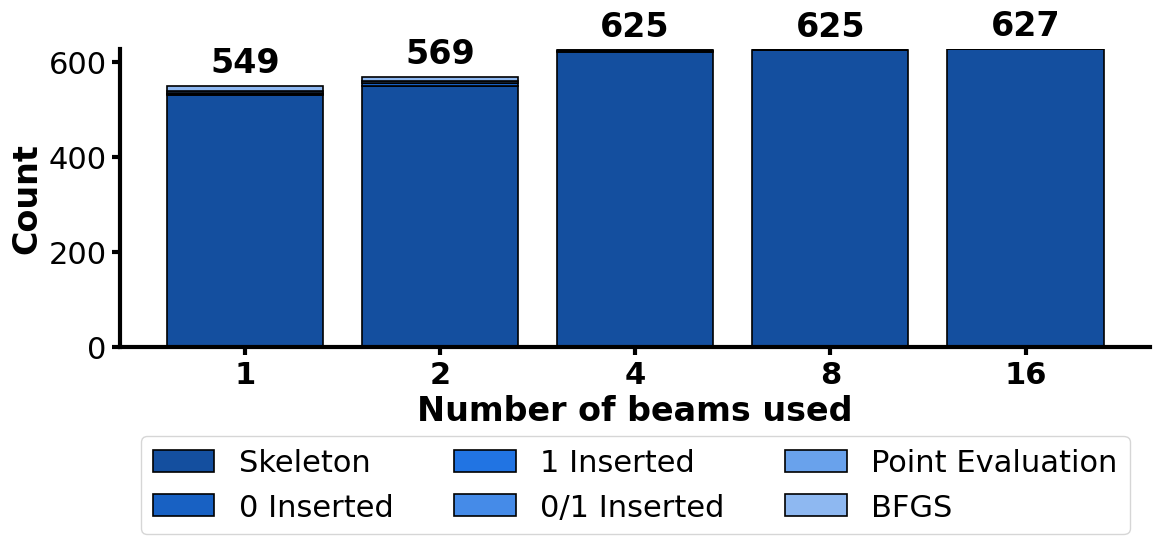

In [4]:
import numpy as np
from vis_utils import plot_frequency_stacked

# Beam sizes to load
beam_sizes = [1, 2, 4, 8, 16]
base_path = "../../data/Arco/Datasets/results_1000_beam_{}.npz"

# Categories
keys = ["no_help", "zero", "one", "zeroone", "point", "bfgs"]

names = [{f"{beam_size}": ["Skeleton", "0 Inserted", "1 Inserted", "0/1 Inserted", "Point Evaluation", "BFGS"]} for beam_size in beam_sizes]

# Initialize heights list
heights = []

# Load results for each beam size
for beam in beam_sizes:
    results = np.load(base_path.format(beam), allow_pickle=True)
    
    # Ensure each category exists, otherwise use 0
    heights.append([len(results[key]) if key in results else 0 for key in keys])

print(heights)
# Plot the stacked bar chart
plot_frequency_stacked(
    names, heights, title="",
    x_axis_name="Number of beams used", y_axis_name="Count", show_percentage=False,
    title_padding=40, legend_padding=-.25, legend_include_percentage=False,
    save_fig=True, save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/Successful_Equation_Recreation_Across_Beam_Sizes_Out_of_1000_Samples.pdf"
)


[[4, 3, 4, 0, 9, 14], 17, 0]
Total entries: 51


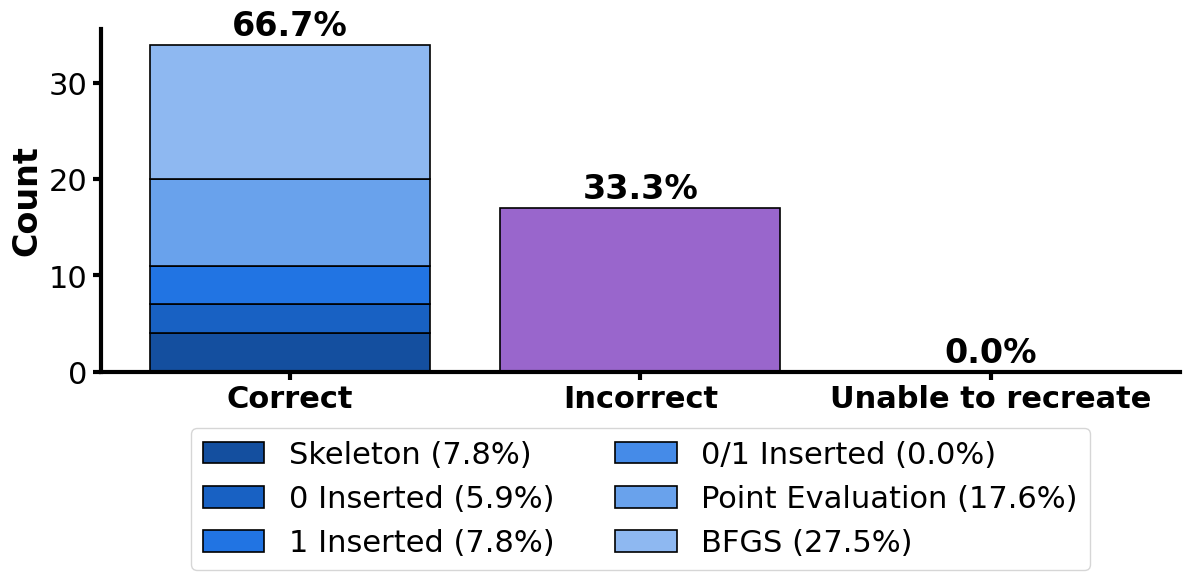

In [6]:
results = np.load("../../data/Arco/Datasets/results_feynman_full_eval_200samples.npz", allow_pickle=True) 


total = sum([len(results['recreated_skeleton']), len(results['recreated_0']), len(results['recreated_1']), len(results['recreated_01']), 
             len(results['recreated_point_eval']), len(results['recreated_BFGS']), 
             len(results['not_recreated']),
             len(results['unable_to_recreate'])])
names = [
        {"Correct": ["Skeleton", "0 Inserted", "1 Inserted", "0/1 Inserted", "Point Evaluation", "BFGS"]},
        "Incorrect",
        "Unable to recreate",
        #"blub", "bliep"
    ]
heights = [
    [len(results['recreated_skeleton']), len(results['recreated_0']), len(results['recreated_1']), len(results['recreated_01']), 
             len(results['recreated_point_eval']), len(results['recreated_BFGS'])],
    len(results['not_recreated']),
    len(results['unable_to_recreate'])
]
print(heights)

plot_frequency_stacked(names, heights, title="",
               x_axis_name="", y_axis_name="Count", legend_padding=-0.12, legend_cols=2,
               save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/Model_Performance_Feyman_AI_Dataset.pdf")

[[6, 3, 2, 2, 9, 12], 17, 0]
Total entries: 51


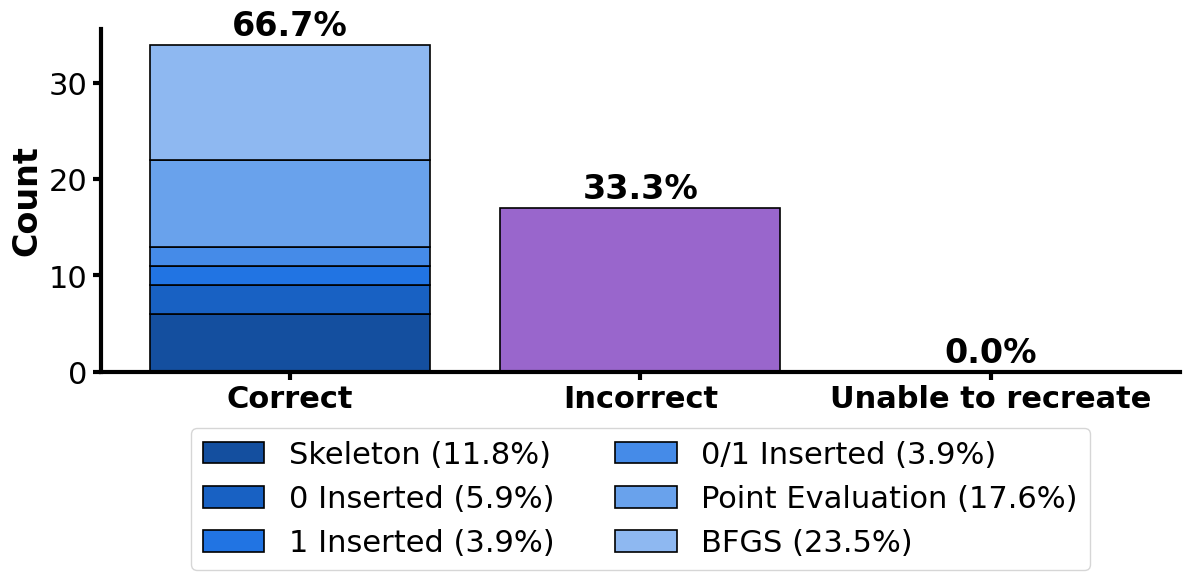

In [7]:
results = np.load("../../data/Arco/Datasets/results_feynman_full_eval_1000samples.npz", allow_pickle=True) 


total = sum([len(results['recreated_skeleton']), len(results['recreated_0']), len(results['recreated_1']), len(results['recreated_01']), 
             len(results['recreated_point_eval']), len(results['recreated_BFGS']), 
             len(results['not_recreated']),
             len(results['unable_to_recreate'])])
names = [
        {"Correct": ["Skeleton", "0 Inserted", "1 Inserted", "0/1 Inserted", "Point Evaluation", "BFGS"]},
        "Incorrect",
        "Unable to recreate",
        #"blub", "bliep"
    ]
heights = [
    [len(results['recreated_skeleton']), len(results['recreated_0']), len(results['recreated_1']), len(results['recreated_01']), 
             len(results['recreated_point_eval']), len(results['recreated_BFGS'])],
    len(results['not_recreated']),
    len(results['unable_to_recreate'])
]
print(heights)

plot_frequency_stacked(names, heights, title="", legend_cols=2,
               x_axis_name="", y_axis_name="Count", legend_padding=-0.12, save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/Model_Performance_Feyman_AI_Dataset_1000_Samples.pdf")

NpzFile '../../data/Arco/Datasets/results_10000_full_eval_no_constants.npz' with keys: no_help, zero, one, zeroone, point...
[[5746, 101, 135, 32, 76, 35], 700, 3175]
6125
2*x_1 - x_2/x_3 	 2*x_1 - x_2/x_3
x_1/x_2**4 	 x_1/(x_2**4*(c + 1))
-sin(x_2) + tan(x_1**2) 	 -sin(c*x_2) + tan(x_1**2)
cos(x_1*(x_2 + 1)) 	 cos(x_1*(c*x_1 + c + x_2))
x_1*(x_1*x_2 + x_1 + 1) 	 x_1*(x_1*(x_2 + 1) + 1)
{'datapoint': {'equation': '2*x_1 - x_2/x_3', 'variables': {'x_2', 'x_3', 'x_1'}, 'prefix': ['add', 'mul', '2', 'x_1', 'mul', '-1', 'mul', 'x_2', 'pow', 'x_3', '-1']}, 'recreation': {'equation': '2*x_1 - x_2/x_3', 'prefix': ['<S>', 'add', 'mul', '2', 'x_1', 'mul', '-1', 'mul', 'x_2', 'pow', 'x_3', '-1'], 'beam_idx': 0}}
Total entries: 10000


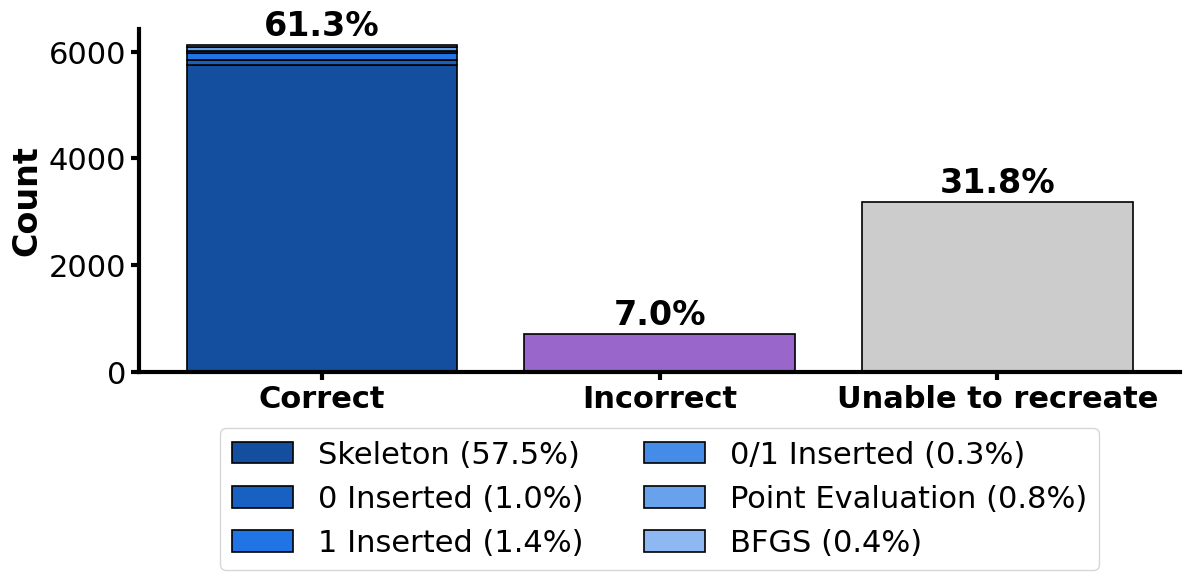

In [9]:
results = np.load("../../data/Arco/Datasets/results_10000_full_eval_no_constants.npz", allow_pickle=True) 
print(results)

names = [
        {"Correct": ["Skeleton", "0 Inserted", "1 Inserted", "0/1 Inserted", "Point Evaluation", "BFGS"]},
        "Incorrect",
        "Unable to recreate",
        #"blub", "bliep"
    ]
heights = [
    [len(results['no_help']), len(results['zero']), len(results['one']), len(results['zeroone']), 
     len(results['point']), len(results['bfgs'])],
    len(results['incorrect']),
    len(results['cnr'])
]

print(heights)
print(sum(heights[0]))
print(results["no_help"][0]["datapoint"]["equation"], "\t", results["no_help"][0]["recreation"]["equation"])
print(results["zero"][0]["datapoint"]["equation"], "\t", results["zero"][0]["recreation"]["equation"])
print(results["one"][0]["datapoint"]["equation"], "\t", results["one"][0]["recreation"]["equation"])
print(results["zeroone"][0]["datapoint"]["equation"], "\t", results["zeroone"][0]["recreation"]["equation"])
print(results["point"][0]["datapoint"]["equation"], "\t", results["point"][0]["recreation"]["equation"])
print(results["no_help"][0])
# print(results["bfgs"][0]["datapoint"]["equation"], "\t", results["bfgs"][0]["recreation"]["equation"])

plot_frequency_stacked(names, heights, title="", legend_cols=2,
               x_axis_name="", y_axis_name="Count", legend_padding=-0.12,
               save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/Model_Performance_on_10000_Samples.pdf")


5445


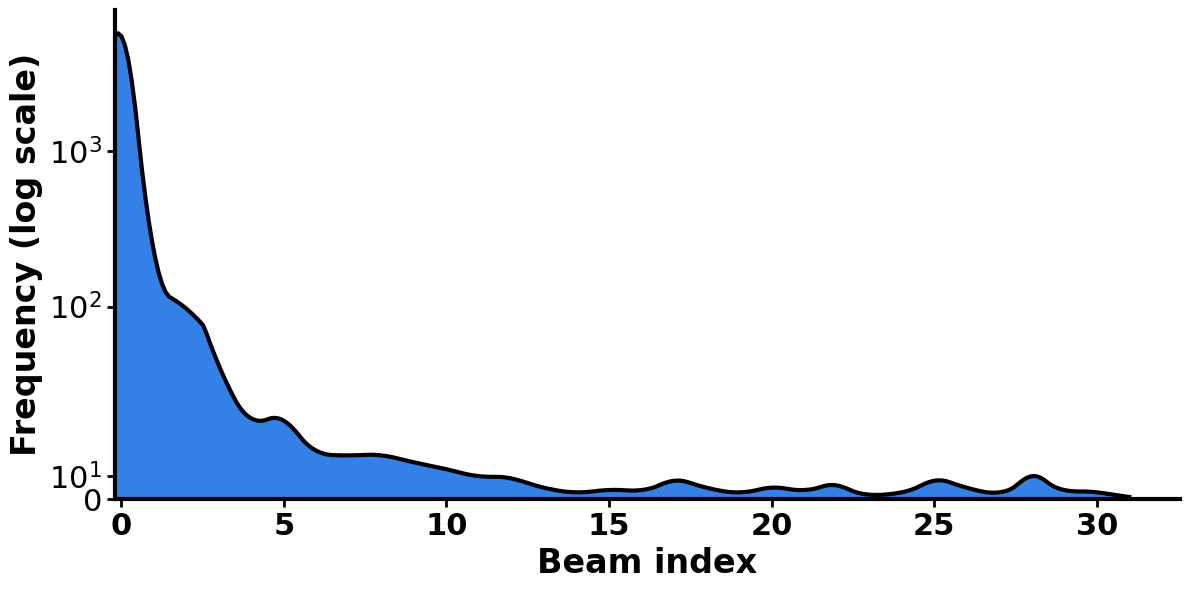

In [11]:
results = np.load("../../data/Arco/Datasets/results_10000_full_eval_no_constants.npz", allow_pickle=True) 
all_results = []
for key in ["no_help", "zero", "one", "zeroone", "point"]:
    temp = []
    for datapoint in results[key]:
        temp.append(datapoint["recreation"]["beam_idx"])
    all_results.append(temp)


from utils import flatten
bliep = flatten(all_results)
print(Counter(bliep)[0])
bliep += [-0.2] * Counter(bliep)[0]
plot_distribution(bliep, scale='symlog',linthresh=75, 
                  title="",
                  x_axis_name="Beam index", save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/Solution_Distribution_Across_Beam_Search.pdf")


In [ ]:
results = np.load("../../data/Arco/Datasets/results_1000_full_eval.npz", allow_pickle=True) 
print(results)

names = [
        {"Correct": ["Skeleton", "0 Inserted", "1 Inserted", "0/1 Inserted", "Point Evaluation", "BFGS"]},
        "Incorrect",
        "Unable to recreate",
    ]
heights = [
    [len(results['no_help']), len(results['zero']), len(results['one']), len(results['zeroone']), 
     len(results['point']), len(results['bfgs'])],
    len(results['incorrect']),
    len(results['cnr'])
]

print(heights)


title="Model Performance on 1000 Samples"
plot_frequency_stacked(names, heights, title=title, legend_cols=2,
               x_axis_name="", y_axis_name="Count", legend_padding=-0.12, save_fig=False)

NpzFile '../../data/Arco/Datasets/results_1000_full_eval.npz' with keys: no_help, zero, one, zeroone, point...
[[585, 9, 5, 2, 6, 3], 72, 318]
Total entries: 1000


{'datapoint': {'equation': 'x_1*(x_1*(x_1 + sin(x_1)) + 1)', 'variables': {'x_1'}, 'prefix': ['mul', 'x_1', 'add', 'mul', 'x_1', 'add', 'x_1', 'sin', 'x_1', '1']}, 'recreation': {'equation': 'x_1*(x_1*(x_1 + sin(x_1)) + 1)', 'prefix': ['<S>', 'add', 'x_1', 'mul', 'pow', 'x_1', '2', 'add', 'x_1', 'sin', 'x_1'], 'beam_idx': 0}}
{'equation': '3.035*x_1 - x_2/x_3', 'variables': {'x_2', 'x_3', 'x_1'}, 'prefix': ['add', 'mul', '3.03500000000000', 'x_1', 'mul', '-1', 'mul', 'x_2', 'pow', 'x_3', '-1'], 'c': ['-x_1 - x_2/x_3', '-x_2/x_3']}
[[171, 3, 0, 0, 9, 246], 179, 392]
Total entries: 1000


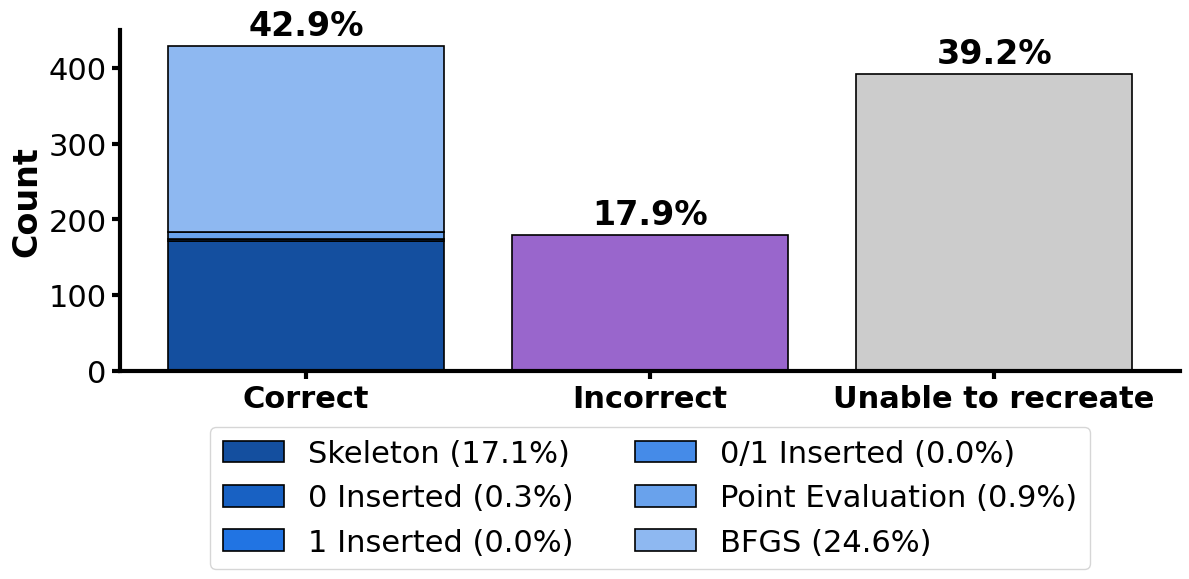

In [ ]:
results = np.load("../../data/Arco/Datasets/results_1000_full_eval_constants.npz", allow_pickle=True) 
print(results["no_help"][0])
print(results["bfgs"][0])

names = [
        {"Correct": ["Skeleton", "0 Inserted", "1 Inserted", "0/1 Inserted", "Point Evaluation", "BFGS"]},
        "Incorrect",
        "Unable to recreate",
    ]
heights = [
    [len(results['no_help']), len(results['zero']), len(results['one']), len(results['zeroone']), 
     len(results['point']), len(results['bfgs'])],
    len(results['incorrect']),
    len(results['cnr'])
]

print(heights)


plot_frequency_stacked(names, heights, title="", legend_cols=2,
               x_axis_name="", y_axis_name="Count", title_padding=25, legend_padding=-0.12,
               save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/Model_Performance_on_1000_Samples_with_Constants.pdf")

In [14]:
full_dataset = np.load("../../data/Arco/Datasets/results_10000_full_eval_no_constant.npz", allow_pickle=True)
recreated_skeleton = full_dataset["recreated_skeleton"]
recreated_0 = full_dataset["recreated_0"]
recreated_1 = full_dataset["recreated_1"]
recreated_01 = full_dataset["recreated_01"]
recreated_point_eval = full_dataset["recreated_point_eval"]
recreated_BFGS = full_dataset["recreated_BFGS"]
not_recreated = full_dataset["not_recreated"]
unable_to_recreate = full_dataset["unable_to_recreate"]

all_correct = np.concatenate((recreated_skeleton, recreated_0, recreated_1, recreated_01, recreated_point_eval, recreated_BFGS))

(6220,) {'datapoint': {'equation': '2*x_1 - x_2/x_3', 'variables': {'x_2', 'x_3', 'x_1'}, 'prefix': ['add', 'mul', '2', 'x_1', 'mul', '-1', 'mul', 'x_2', 'pow', 'x_3', '-1']}, 'recreation': {'equation': '2*x_1 - x_2/x_3', 'prefix': ['<S>', 'add', 'mul', '2', 'x_1', 'mul', '-1', 'mul', 'x_2', 'pow', 'x_3', '-1']}}
total_entries: 41975


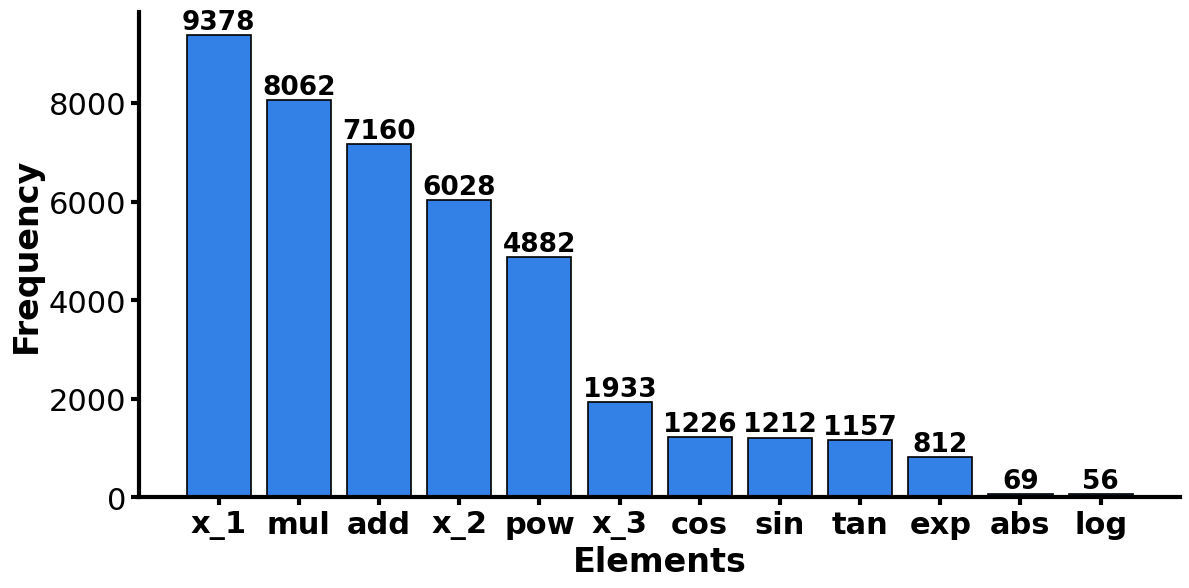

In [15]:
from collections import Counter
from vis_utils import plot_frequency

print(all_correct.shape, all_correct[0])
exclude = ["1", "-1", "2", "3", "4", "_", "x", "5", "-2"]
prefs = [pref for sample in all_correct for pref in sample["datapoint"]["prefix"] if not pref in exclude]

counter_dict = Counter(prefs)
sorted_items_correct = sorted(counter_dict.items(), key=lambda x: x[1], reverse=True)
sorted_keys_correct, sorted_values_correct = zip(*sorted_items_correct)

untill = 12
plot_frequency(sorted_keys_correct[:untill], sorted_values_correct[:untill], "",
                save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/True_Equations_Correctly_Recreated.pdf")

(1002,) {'datapoint': {'equation': 'sin(tan(exp(x_1*x_2)))', 'variables': {'x_2', 'x_1'}, 'prefix': ['sin', 'tan', 'exp', 'mul', 'x_1', 'x_2']}, 'recreation': {'equation': 'sin(exp(x_1*(c*x_3 + x_2)))', 'prefix': ['<S>', 'sin', 'exp', 'mul', 'x_1', 'add', 'x_2', 'mul', 'x_3', 'c']}, 'c': ['sin(exp(x_1*x_2))', 'sin(exp(x_1*(x_2 + x_3)))']}
total_entries: 7734


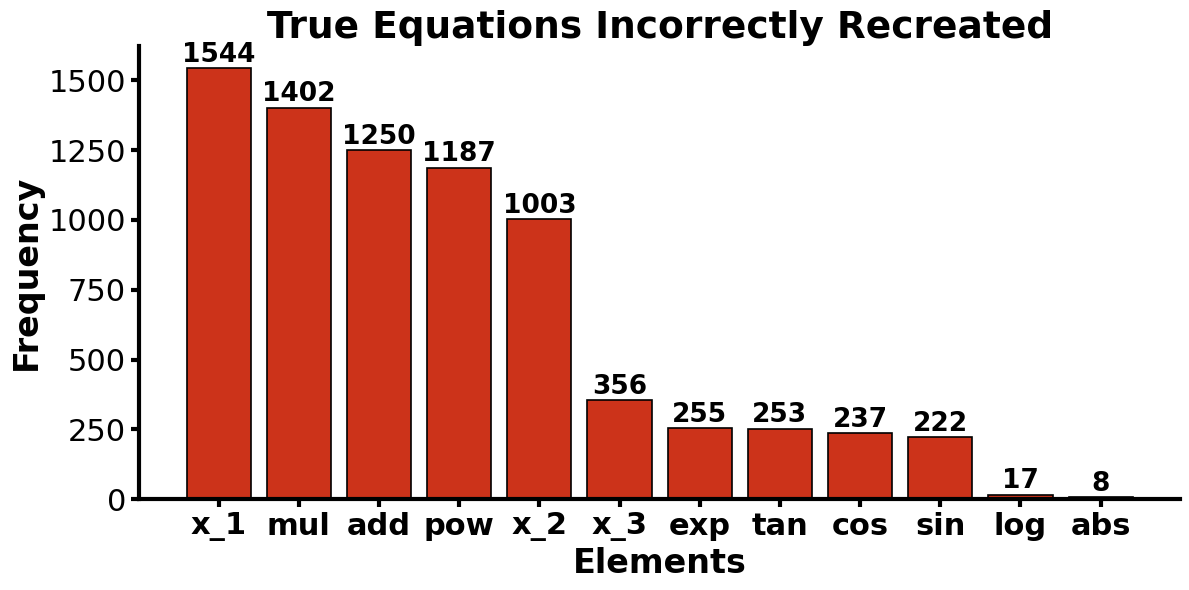

In [16]:
from collections import Counter

print(not_recreated.shape, not_recreated[0])
exclude = ["1", "-1", "2", "3", "4", "_", "x", "5", "-2", "6", "10", "8", "9", "7", "12"]
prefs = [pref for sample in not_recreated for pref in sample["datapoint"]["prefix"] if not pref in exclude]

counter_dict = Counter(prefs)
sorted_items_incorrect = sorted(counter_dict.items(), key=lambda x: x[1], reverse=True)
sorted_keys_incorrect, sorted_values_incorrect = zip(*sorted_items_incorrect)

untill = 12
plot_frequency(sorted_keys_incorrect[:untill], sorted_values_incorrect[:untill], 
               "True Equations Incorrectly Recreated", color=[.8, .2, .1],
               save_fig=False)

(3174,) {'equation': 'x_1*x_2 + sqrt(x_3) + log(x_1)', 'variables': {'x_2', 'x_3', 'x_1'}, 'prefix': ['add', 'mul', 'x_1', 'x_2', 'add', 'pow', 'x_3', '1/2', 'log', 'x_1']}
total_entries: 24313


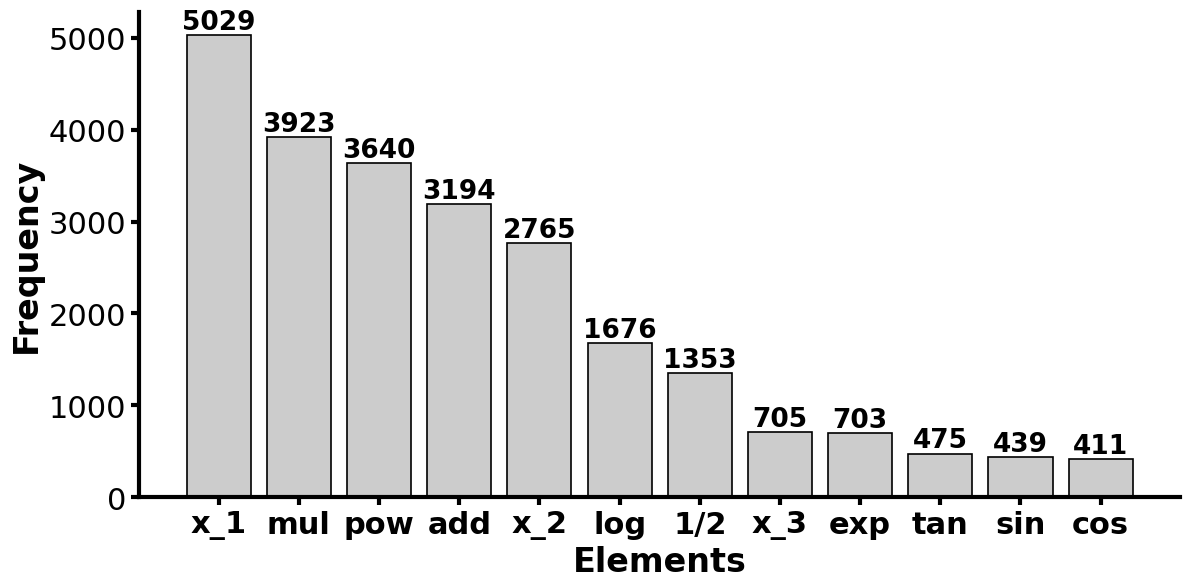

In [17]:
from collections import Counter

print(unable_to_recreate.shape, unable_to_recreate[0])
exclude = ["1", "-1", "2", "3", "4", "_", "x", "5", "-2", "6", "10", "8", "9", "7", "12"]
prefs = [pref for sample in unable_to_recreate for pref in sample["prefix"] if not pref in exclude]

counter_dict = Counter(prefs)
sorted_items_CNR = sorted(counter_dict.items(), key=lambda x: x[1], reverse=True)
sorted_keys_CNR, sorted_values_CNR = zip(*sorted_items_CNR)

untill = 12
plot_frequency(sorted_keys_CNR[:untill], sorted_values_CNR[:untill], "", color=(0.8, 0.8, 0.8),
               save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/True_Equations_could_not_be_Recreated.pdf")

It seems like log is very difficult for the model

In [18]:
print(f"Correct:   {dict(sorted_items_correct)['log']}")
print(f"Incorrect: {dict(sorted_items_incorrect)['log']}")
print(f"CNR:       {dict(sorted_items_CNR)['log']}")

print()
print(f"Correct:   {dict(sorted_items_correct)['exp']}")
print(f"Incorrect: {dict(sorted_items_incorrect)['exp']}")
print(f"CNR:       {dict(sorted_items_CNR)['exp']}")

Correct:   56
Incorrect: 17
CNR:       1676

Correct:   812
Incorrect: 255
CNR:       703


(6220,) {'datapoint': {'equation': '2*x_1 - x_2/x_3', 'variables': {'x_2', 'x_3', 'x_1'}, 'prefix': ['add', 'mul', '2', 'x_1', 'mul', '-1', 'mul', 'x_2', 'pow', 'x_3', '-1']}, 'recreation': {'equation': '2*x_1 - x_2/x_3', 'prefix': ['<S>', 'add', 'mul', '2', 'x_1', 'mul', '-1', 'mul', 'x_2', 'pow', 'x_3', '-1']}}
total_entries: 33355


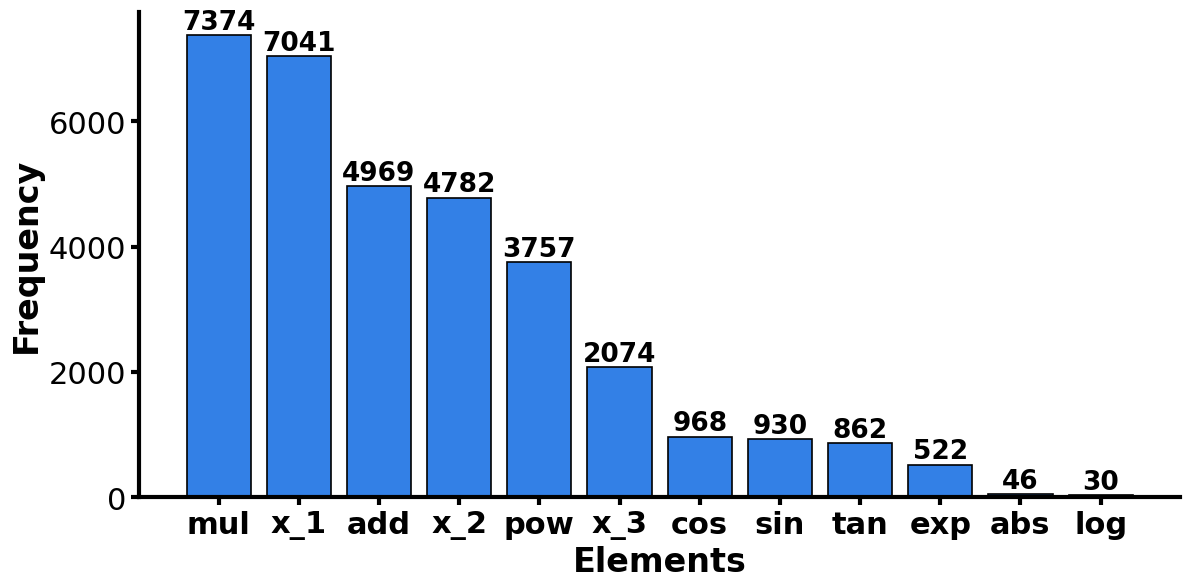

total_entries: 11218


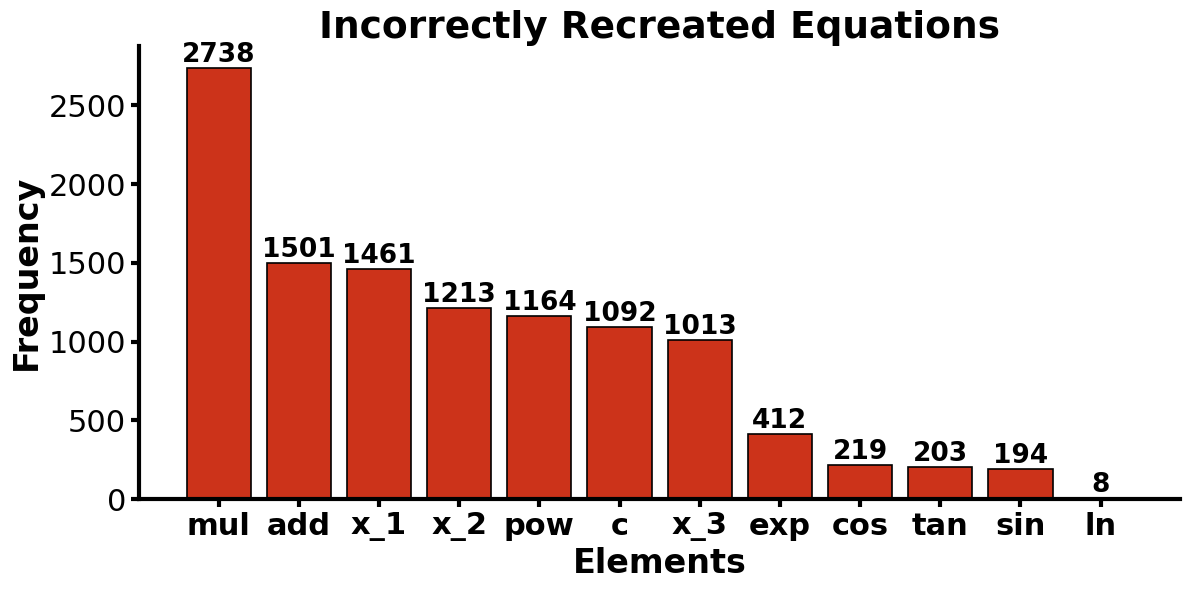

In [19]:
from utils import infix_to_prefix
from collections import Counter

print(all_correct.shape, all_correct[0])
exclude = ["1", "-1", "2", "3", "4", "_", "x", "5", "-2", "6", "10", "8", "9", "7", "12", "<S>", 2, "0", "b", "o", "t", "h", "-3"]
# prefs = [pref for sample in all_correct for pref in sample["c"] if not pref in exclude]
prefs = []
for sample in all_correct:
    c = sample.get("c", None)
    prefix = infix_to_prefix(c) if c is not None else sample["recreation"]["prefix"]
    prefs += [p for p in prefix if p not in exclude]

counter_dict = Counter(prefs)
sorted_items_correct_recreated = sorted(counter_dict.items(), key=lambda x: x[1], reverse=True)
sorted_keys_correct_recreated, sorted_values_correct_recreated = zip(*sorted_items_correct_recreated)

untill = 12

from collections import Counter

prefs = [pref for sample in not_recreated for pref in sample["recreation"]["prefix"] if not pref in exclude]

counter_dict = Counter(prefs)
sorted_items_incorrect_recreated = sorted(counter_dict.items(), key=lambda x: x[1], reverse=True)
sorted_keys_incorrect_recreated, sorted_values_incorrect_recreated = zip(*sorted_items_incorrect_recreated)


plot_frequency(sorted_keys_correct_recreated[:untill], sorted_values_correct_recreated[:untill], "",
               save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/Correctly_Recreated_Equations.pdf")
plot_frequency(sorted_keys_incorrect_recreated[:untill], sorted_values_incorrect_recreated[:untill], "Incorrectly Recreated Equations", color=[.8, .2, .1], save_fig=False)

In [20]:
dataset_with_prefix = np.load(f"../../data/Arco/Datasets/expressions_with_prefix_1000000_constatson_False.npy", allow_pickle=True)

correct = sum(sorted_values_correct) / all_correct.shape[0]
incorrect = sum(sorted_values_incorrect) / not_recreated.shape[0]
CNR = sum(sorted_values_CNR) / not_recreated.shape[0]


correct_recreated = sum(sorted_values_correct_recreated) / all_correct.shape[0]
incorrect_recreated = sum(sorted_values_incorrect_recreated) / not_recreated.shape[0]

print(f"Correct:               {correct:.4f}")
print(f"Incorrect:             {incorrect:.4f}")
print(f"Correct (Recreated):   {correct_recreated:.4f}")
print(f"Incorrect (Recreated): {incorrect_recreated:.4f}")

eq_len_complete = []
for eq in dataset_with_prefix:
    eq_len_complete.append(len(eq["prefix"]))
print(eq_len_complete)
    
eq_len_CNR = []
for eq in unable_to_recreate:
    eq_len_CNR.append(len(eq["prefix"]))

eq_len_corr, recon_len_corr = [], []
for eq in all_correct:
    eq_len_corr.append(len(eq["datapoint"]["prefix"]))
    c = eq.get("c", None)
    prefix = infix_to_prefix(c) if c is not None else eq["recreation"]["prefix"]
    recon_len_corr.append(len(prefix))

eq_len_incorr, recon_len_incorr = [], []
for eq in not_recreated:
    eq_len_incorr.append(len(eq["datapoint"]["prefix"]))
    recon_len_incorr.append(len(eq["recreation"]["prefix"]))

Correct:               6.7534
Incorrect:             7.7605
Correct (Recreated):   5.3887
Incorrect (Recreated): 11.1986
[11, 9, 7, 7, 10, 12, 10, 5, 9, 10, 3, 6, 10, 14, 8, 5, 4, 9, 6, 10, 4, 4, 10, 9, 7, 8, 11, 6, 10, 7, 14, 5, 7, 7, 8, 11, 7, 14, 11, 10, 7, 14, 6, 6, 12, 7, 10, 3, 12, 5, 13, 5, 5, 7, 9, 8, 8, 7, 5, 12, 14, 4, 9, 10, 7, 6, 10, 9, 10, 7, 14, 14, 8, 7, 9, 3, 9, 10, 17, 12, 10, 8, 10, 13, 8, 11, 7, 12, 10, 8, 10, 12, 10, 9, 10, 8, 8, 9, 7, 8, 9, 7, 5, 10, 9, 12, 8, 5, 9, 8, 10, 14, 12, 8, 8, 7, 11, 15, 12, 9, 14, 9, 2, 12, 11, 5, 10, 2, 8, 11, 10, 6, 8, 6, 19, 5, 6, 13, 8, 14, 10, 4, 11, 9, 9, 9, 3, 5, 8, 3, 11, 6, 11, 5, 11, 6, 2, 10, 8, 5, 3, 6, 7, 5, 8, 12, 10, 10, 9, 10, 6, 8, 10, 10, 8, 6, 7, 9, 3, 5, 9, 15, 9, 3, 8, 11, 9, 10, 10, 7, 9, 14, 7, 5, 9, 8, 6, 9, 7, 5, 11, 11, 17, 12, 12, 6, 5, 11, 12, 10, 14, 3, 8, 6, 3, 10, 6, 5, 5, 5, 5, 6, 10, 6, 3, 11, 8, 3, 6, 7, 6, 8, 6, 6, 7, 11, 10, 12, 9, 6, 9, 14, 6, 2, 6, 8, 9, 7, 3, 14, 13, 8, 8, 5, 8, 6, 11, 7, 10, 8, 9, 

[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,

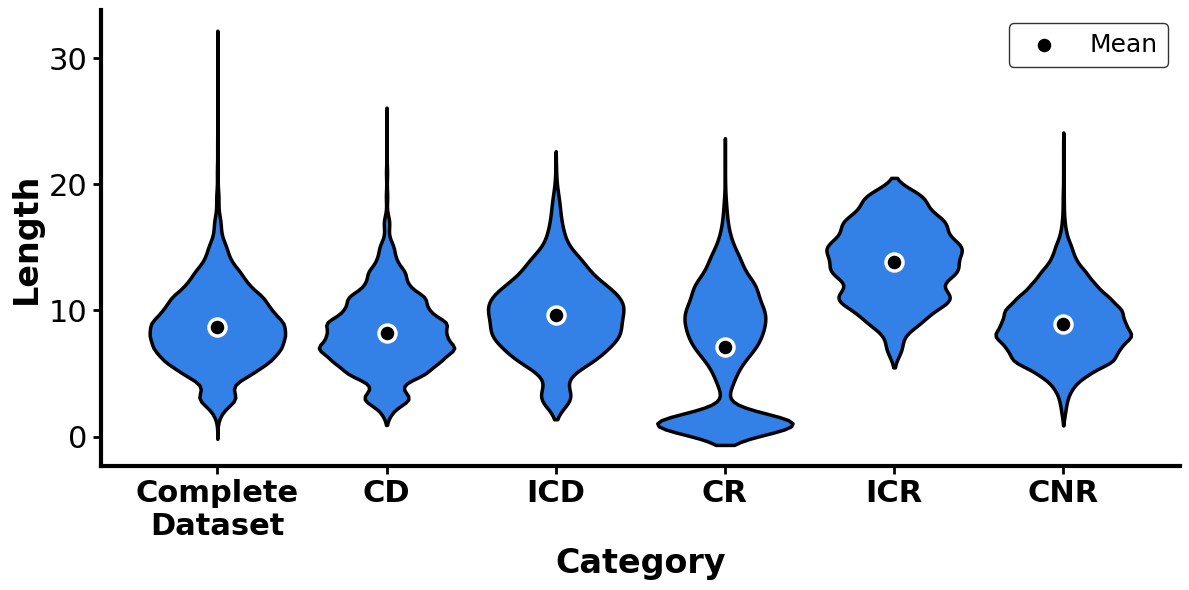

In [21]:
from vis_utils import plot_violin

counter = Counter(eq_len_complete)

bliep = []
for key in sorted(counter.keys()):
    # print(f"{key}: {counter[key]}")
    bliep.append(counter[key])
    
counter = Counter(eq_len_complete)
listt = []
for key, value in counter.items():
    listt += [key]*max(int(value/200), 1)
    
print(listt)

plot_violin(
    [listt, eq_len_corr, eq_len_incorr,  recon_len_corr, recon_len_incorr, eq_len_CNR,],
    labels=["Complete\nDataset", "CD", "ICD", "CR", "ICR", "CNR"],
    title="",
    violin_color=(0.2, 0.5, 0.9),
    y_axis_name="Length",
    save_name="/home/arco/Downloads/Master/MscThesis/ExplainableDSR/pictures/modelperformance/Mean_Equation_Length_Across_Data_Segments.pdf"

)
